# Keras API

In [1]:
import os
import sys
import pickle
from datetime import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Input, InputLayer
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten

%matplotlib inline

Using TensorFlow backend.


### Loading dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data


save_dir = '../saved/convnet/practise/keras'
data_dir = '../datasets/MNIST'
saved_data = os.path.join(save_dir, f'data/{os.path.basename(data_dir)}.pkl')

if not os.path.isfile(saved_data):
    start = dt.now()
    data = input_data.read_data_sets(data_dir, one_hot=True)
    print(f'Took {dt.now() - start}')
    if not os.path.exists(os.path.dirname(saved_data)):
        os.makedirs(os.path.dirname(saved_data))
    pickle.dump(file=open(saved_data, 'wb'), obj=data)
    
    print('\nCached data for future use.')
else:
    start = dt.now()
    data = pickle.load(file=open(saved_data, 'rb'))
    print('Loaded cached data.')
    print(f'Took {dt.now() - start}')

data.test.cls = np.argmax(data.test.labels, axis=1)

# free memory
del start

Loaded cached data.
Took 0:00:00.306695


### Hyperparameters

In [3]:
# Data dimension
img_channel = 1
img_size = 28
img_size_flat = img_size * img_size * img_channel
num_classes = 10
num_test = data.test.num_examples

# Network
kernel_size = 5
filter_1 = 32
filter_2 = 64
fc_size = 256
dropout = 0.8

# Training
train_batch = 100
test_batch = 50
val_batch = 25
learning_rate = 1e-2
n_iters = 0  # Total number of completed optimization iterations
save_interval = 100

### Visualization helpers

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape([img_size, img_size]), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle('Metrics')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.test.cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

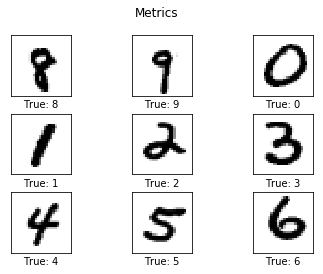

In [5]:
start = np.random.randint(num_test-9)
end = start + 9

imgs = data.test.images[start:end]
cls_true = data.test.cls[start:end]

plot_images(imgs, cls_true=cls_true)

# Free memory
del start, end, imgs, cls_true

### The Keras `Sequential()` model

In [6]:
model = Sequential()
# Input layer
model.add(InputLayer(input_shape=[img_size_flat]))
model.add(Reshape(target_shape=[img_size, img_size, img_channel]))
# 1st conv layer
model.add(Conv2D(filters=filter_1, kernel_size=kernel_size, 
                 padding='same', activation='relu',
                 name='layer_conv1'))
model.add(MaxPooling2D(strides=2, padding='same'))
# 2nd conv layer
model.add(Conv2D(filters=filter_2, kernel_size=kernel_size,
                 padding='same', activation='relu',
                 name='layer_conv2'))
model.add(MaxPooling2D(strides=2, padding='same'))
# flatten layer
model.add(Flatten())
# Fully connected layer
model.add(Dense(units=fc_size, activation='relu'))
# Output layer
model.add(Dense(units=num_classes, activation='softmax'))

### Compilation

In [7]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

### Training model

In [8]:
model.fit(x=data.train.images, y=data.train.labels, epochs=1, batch_size=train_batch)

Epoch 1/1
55000/55000 [==============================] - 172s 3ms/step - loss: 0.1493 - acc: 0.9529

### Evaluate

In [10]:
result = model.evaluate(x=data.test.images, y=data.test.labels)

for name, value in zip(model.metrics_names, result):
    print(f'{name.capitalize()} = {value:.2%}')

10000/10000 [==============================] - 11s 1ms/step

### Prediction

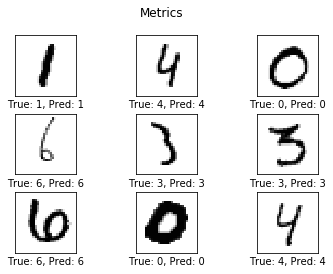

In [11]:
start = np.random.randint(num_test-9)
end = start + 9

imgs = data.test.images[start:end]
cls_true = data.test.cls[start:end]

y_pred = model.predict(x=imgs)
cls_pred = np.argmax(y_pred, axis=1)

plot_images(imgs, cls_true=cls_true, cls_pred=cls_pred)

del imgs, cls_true, y_pred, cls_pred

### Mis classification

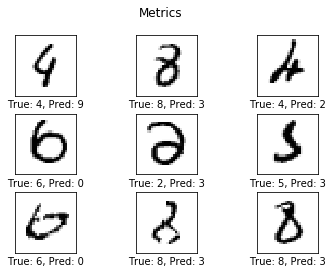

In [12]:
y_pred = model.predict(x=data.test.images)
cls_pred = np.argmax(y_pred, axis=1)

plot_example_errors(cls_pred=cls_pred)

del y_pred, cls_pred